In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data scaling

In [2]:
data = pd.read_csv('16P.csv', encoding="windows 1252", nrows=60000)
data.drop("Response Id", axis=1, inplace=True)
personality_map = {"ESTJ": 0, "ENTJ": 1, "ESFJ": 2, "ENFJ": 3, "ISTJ": 4, "ISFJ": 5, "INTJ": 6, "INFJ": 7, "ESTP": 8,
                   "ESFP": 9, "ENTP": 10, "ENFP": 11, "ISTP": 12, "ISFP": 13, "INTP": 14, "INFP": 15}
data["Personality"] = data["Personality"].replace(personality_map)

### Split the data into two sets

In [3]:
predictors, target = data.iloc[:, :-1], data.iloc[:, -1]
predictors = predictors.to_numpy()
target = target.to_numpy()

### k-NN functions

In [4]:
def get_k_neighbors(training_data, test_point, k_):
    distance = np.sum(np.square(np.subtract(training_data, test_point)), axis=1)
    k_neighbors = np.argsort(distance)[:k_]
    return k_neighbors

In [5]:
def predict(training_data, training_labels, test_point, k_):
    k_neighbors = get_k_neighbors(training_data, test_point, k_)
    k_neighbor_labels = training_labels[k_neighbors]
    return np.argmax(np.bincount(k_neighbor_labels))

## Accuracy, precision, recall funcitons

In [6]:
def accuracy(prediction_values, target_test):
    return np.mean(prediction_values == target_test)

In [7]:
def precision(prediction_values, target_test):
    precisionss = []
    for j in range(16):
        true_positives = np.sum((prediction_values == target_test) & (target_test == j))
        false_positives = np.sum((prediction_values != target_test) & (prediction_values == j))
        precisionss.append(true_positives / (true_positives + false_positives)+1e-8) # 1e-8 to prevent divison by zero
    macro_average_precision = np.mean(precisionss)
    return macro_average_precision

In [8]:
def recall(prediction_values, target_test):
    recallss = []
    for j in range(16):
        true_positives = np.sum((prediction_values == target_test) & (target_test == j))
        false_negatives = np.sum((prediction_values != target_test) & (target_test == j))
        recallss.append(true_positives / (true_positives + false_negatives)+1e-8) # 1e-8 to prevent divison by zero
    macro_average_recall = np.mean(recallss)
    return macro_average_recall

## Feature normalization

In [9]:
def min_max_normalize(x):
    min_val = x.min(axis=0)
    max_val = x.max(axis=0)
    return (x - min_val) / (max_val - min_val)

## k-fold Cross validation

In [10]:
fold_size = int(predictors.shape[0] / 5)
for i in range(5):
    print(f"Fold {i + 1}")
    start = i * fold_size
    end = start + fold_size
    p_test = predictors[start:end] # p prefixes stands for predictors
    t_test = target[start:end]     # t prefixes stands for target
    p_train = np.concatenate([predictors[:start], predictors[end:]])
    t_train = np.concatenate([target[:start], target[end:]])
    p_train_norm = min_max_normalize(p_train)
    p_test_norm = min_max_normalize(p_test)
    accuracies, precisions, recalls, precisions_norm, recalls_norm, accuracies_norm = {}, {}, {}, {}, {}, {}
    for k in [1, 3, 5, 7, 9]:
        print(f"\nWithout Normalization")
        print(f"k = {k}")
        predictions = np.apply_along_axis(lambda x: predict(p_train, t_train, x, k), 1, p_test)
        precisions[k] = precision(predictions, t_test)
        recalls[k] = recall(predictions, t_test)
        accuracies[k] = accuracy(predictions, t_test)
        print("Precision:", precisions[k])
        print("Recall:", recalls[k])
        print("Accuracy:", accuracies[k])
        print(f"\nWith Normalization")
        print(f"k = {k}")
        predictions_n = np.apply_along_axis(lambda x: predict(p_train_norm, t_train, x, k), 1, p_test_norm)
        precisions_norm[k] = precision(predictions_n, t_test)
        recalls_norm[k] = recall(predictions_n, t_test)
        accuracies_norm[k] = accuracy(predictions_n, t_test)
        print("Precision:", precisions_norm[k])
        print("Recall:", recalls_norm[k])
        print("Accuracy:", accuracies_norm[k])

Fold 1

Without Normalization
k = 1
Precision: 0.978920871072791
Recall: 0.9788689406376444
Accuracy: 0.978914909575798

With Normalization
k = 1
Precision: 0.9728546945899248
Recall: 0.9728353955003747
Accuracy: 0.9728310692557713

Without Normalization
k = 3
Precision: 0.9885669476610288
Recall: 0.9884514126738111
Accuracy: 0.9884990415867989

With Normalization
k = 3
Precision: 0.9863908543588114
Recall: 0.9863042085437428
Accuracy: 0.9863321943495291

Without Normalization
k = 5
Precision: 0.9893755039498155
Recall: 0.9892943195000277
Accuracy: 0.9893324443703642

With Normalization
k = 5
Precision: 0.9889531928683013
Recall: 0.9888851646384659
Accuracy: 0.9889157429785815

Without Normalization
k = 7
Precision: 0.9896198833175994
Recall: 0.98954598837066
Accuracy: 0.9895824652054338

With Normalization
k = 7
Precision: 0.9889456917958135
Recall: 0.9888731858765143
Accuracy: 0.9889157429785815

Without Normalization
k = 9
Precision: 0.989614918858621
Recall: 0.9895475933899335
Accu

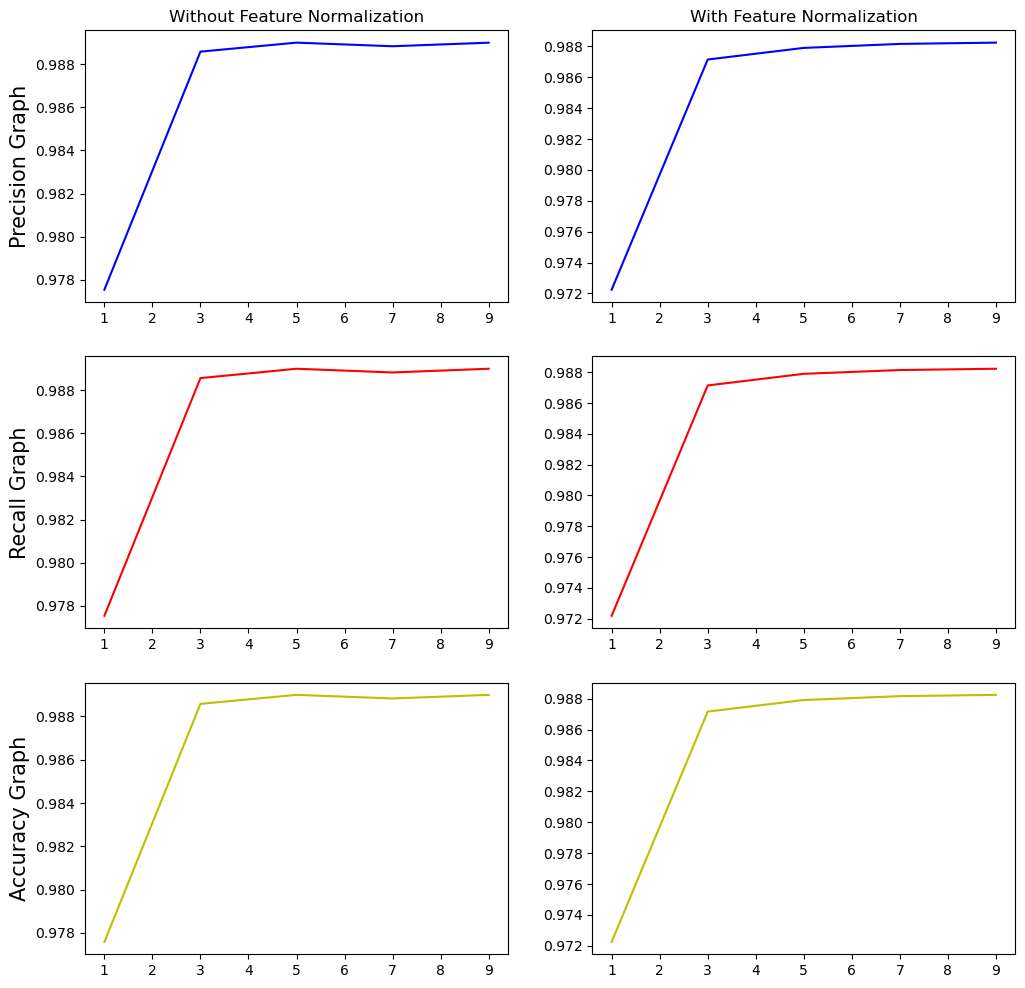

In [11]:
fig, axs = plt.subplots(3,2,figsize=(12,12))
axs[0,0].plot(precisions.keys(),precisions.values(), 'b')
axs[1,0].plot(recalls.keys(),recalls.values(), 'r')
axs[2,0].plot(accuracies.keys(),accuracies.values(), 'y')
axs[0,0].set_title('Without Feature Normalization')
axs[0,1].set_title('With Feature Normalization')
axs[0,0].set_ylabel('Precision Graph',fontsize = 15)
axs[1,0].set_ylabel('Recall Graph',fontsize = 15)
axs[2,0].set_ylabel('Accuracy Graph',fontsize = 15)
axs[0,1].plot(precisions_norm.keys(),precisions_norm.values(), 'b')
axs[1,1].plot(recalls_norm.keys(),recalls_norm.values(), 'r')
axs[2,1].plot(accuracies_norm.keys(),accuracies_norm.values(), 'y')
plt.show()

### Error Analysis For Classification
***Effect of neighbour number (K)***
    The k value in the k-NN algorithm defines how many neighbors will be checked to determine the classification of a specific query point.As we can see from the graphs above, k has a positive effect on precision,accuracy and recall. However, for the first part, after k(3) there are some drops on values. Without normalization we can say k(3) is the most effective number. In feature normalization part graphs are always increasing but after k(5) we do not see a efficent increase.
    ***Effect of normalization***
    Min-max normalization is used to perform a linear transformation on the original data. This technique gets all the scaled data in the range (0, 1). Although it makes the algortihm a bit faster, we do not see a drastic change. The noticeable change happens when we compare after the value k(5). While using feature normalization all the values ( precision, recall, accuracy) increases after k(5). This shows us min-max normalization has a positive effect on the model but its efficency is arguable (considering extra computations).
    ***Effect of algorithm***
    This code uses k-nearest neighbour algorithm. It uses eucladian distance method. We can see this algortihm is very efective for the dataset. Our precision, recall and accuracy values are significantly higher after k(3).
    ***Effect of k-fold cross validation***
     Cross validation provides a more robust estimate of the performance of the k-nearest neighbors algorithm on the given data. By training and testing the model multiple times using different subsets of the data, the k-fold cross-validation method can reduce the impact of any sampling bias that might be present in a single train-test split of the data. This can lead to a more accurate estimate of the model's performance and can help identify any overfitting or underfitting that might occur. It also guarantees that our model is not a coincidence :)
     ***Precision,Recall,Accuracy***
     Overall, I think my model worked pretty well. We have high precision, recall and accuracy values like 0.988.